<a href="https://colab.research.google.com/github/leadbreak/invest_supporter/blob/master/stock_project_250.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1년 데이터 학습 & 예측

# tensorflow hotfix install

In [ ]:
!pip install tf-nightly

# Import libraries & Google driver mount

In [ ]:
import tensorflow as tf
import tensorflow.keras.layers
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Nadam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# #1 STARBUCKS

train data % : 5.5 test data % : 18.0
Epoch 1/200
13/13 [==============================] - 4s 66ms/step - loss: 0.7306 - accuracy: 0.4279 - val_loss: 0.6480 - val_accuracy: 0.9158

Epoch 00001: val_loss improved from inf to 0.64801, saving model to /content/gdrive/My Drive/Colab Notebooks/model/stock_03.hdf5
Epoch 2/200
13/13 [==============================] - 0s 9ms/step - loss: 0.6182 - accuracy: 0.7308 - val_loss: 0.5644 - val_accuracy: 0.8105

Epoch 00002: val_loss improved from 0.64801 to 0.56438, saving model to /content/gdrive/My Drive/Colab Notebooks/model/stock_03.hdf5
Epoch 3/200
13/13 [==============================] - 0s 9ms/step - loss: 0.5486 - accuracy: 0.8757 - val_loss: 0.4861 - val_accuracy: 0.8105

Epoch 00003: val_loss improved from 0.56438 to 0.48611, saving model to /content/gdrive/My Drive/Colab Notebooks/model/stock_03.hdf5
Epoch 4/200
13/13 [==============================] - 0s 9ms/step - loss: 0.4877 - accuracy: 0.9049 - val_loss: 0.4329 - val_accuracy: 0.8105

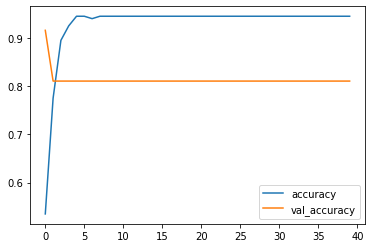

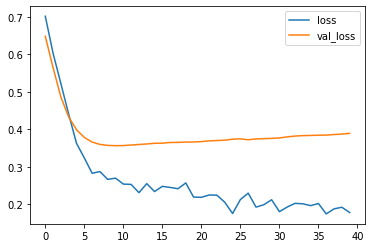

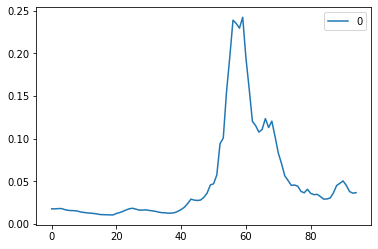

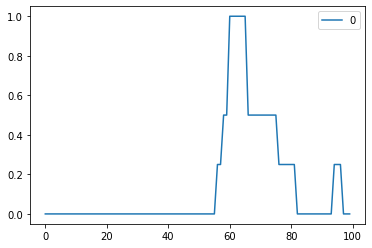

In [ ]:
df = pd.read_csv("/content/gdrive/My Drive/SBUX_rev.2.csv")

df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']

# 주식 데이터 및 금 시세 데이터를 로짓
df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

# 조정종가를 종가로 나눈 값 : 이는 단순 재무 수치 이외의 기업적인 이벤트를 의미
df['gap'] = df['adj']/df['close'] 

# 5일 평균 조정종가 산정, 타겟 블록화
df['mov5'] = df['adj'].rolling(5).mean()

# 특정 기간 이후의 수익율 산정(1년치 데이터 학습 모델의 경우 향후 6개월까지만)
df['1d'] = (df['mov5'].shift(-1) - df['mov5'])/df['mov5']
df['1w'] = (df['mov5'].shift(-5) - df['mov5'])/df['mov5']
df['2w'] = (df['mov5'].shift(-10) - df['mov5'])/df['mov5']
df['4w'] = (df['mov5'].shift(-20) - df['mov5'])/df['mov5']
df['6w'] = (df['mov5'].shift(-30) - df['mov5'])/df['mov5']
df['8w'] = (df['mov5'].shift(-40) - df['mov5'])/df['mov5']
df['10w'] = (df['mov5'].shift(-50) - df['mov5'])/df['mov5']
df['12w'] = (df['mov5'].shift(-60) - df['mov5'])/df['mov5']
df['18w'] = (df['mov5'].shift(-90) - df['mov5'])/df['mov5']
df['24w'] = (df['mov5'].shift(-120) - df['mov5'])/df['mov5']

# 현실적인 수익율을 보수적으로 타겟팅 : 상위 수익율 3,4,5위位의 평균
df['return'] = (np.sort(df.iloc[:,14:],axis=1)[:,7] + np.sort(df.iloc[:,14:],axis=1)[:,6] + np.sort(df.iloc[:,14:],axis=1)[:,5])/3

# na가 하나라도 있는 열을 모두 제거
df = df.dropna(axis=0)
# 250 주식거래일이 1년이라고 했을 때, 그전의 50거래일이 사전에 영향을 줄 수 있다.
df = df.iloc[-300:,:]

df['return'].describe()

# 수치로 되어있는 수익율을 구간화
def scaler01(row) :
  if row['return'] >= 0.2 : result = 3                # 초고수익율 구간
  elif 0.2 > row['return'] >= 0.1 : result = 2        # 고수익율 구간
  elif 0.1 > row['return'] >= 0.05 : result = 1       # 수익율 구간
  elif 0.05 > row['return'] >= 0.03 : result = 0.5    # 낮은 수익율 구간
  elif 0.03 > row['return'] >= 0.01 : result = 0.25   # 보전 구간(손실은 안나는)
  elif -0.2 < row['return'] <= -0.1 : result = -1     # 확정 손실 구간
  elif -0.3 < row['return'] <= -0.2 : result = -2     # 높은 손실 구간
  elif row['return'] <= -0.3 : result = -3            # 초고 손실 구간
  else : result = 0                                   # 손실 구간
  return result

df['return02'] = df.apply(scaler01,axis=1)

from tensorflow.keras.callbacks import ModelCheckpoint # 좋은 성능을 보인 모델만 저장

modelpath = "/content/gdrive/My Drive/Colab Notebooks/model/stock_03.hdf5" # 저장할 모델 경로와 이름 지정
checkpointer = ModelCheckpoint(filepath = modelpath, monitor = 'val_loss', mode = 'auto', verbose = 1, save_best_only = True) # val_loss값을 기준으로 가장 높은 성능을 저장

from tensorflow.keras.callbacks import EarlyStopping # 과대적합을 피하기 위해 조기에 멈추도록
early_stop = EarlyStopping(monitor = 'val_loss', patience = 30) # val_loss값을 기준으로 개선되지 않으면 30번만 참다가 정지

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values # 변수(X) 지정
target = df['return02'].values # 구하고자하는 값, return02는 구간화한 수익율

T = 5 # 1년 데이터를 학습하는 모델이기 때문에 T값을 제일 작은 5로 설정함으로써 5일치 데이터를 기반으로 그 주의 수익율 예측
D = input_data.shape[1] 
N = len(input_data) - T

# Scaling - must
Ntrain = len(input_data) * 2 // 3
scaler = MinMaxScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

pd.DataFrame(target).describe()

# Xtrain / Ytrain
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain) :
  X_train[t,:,:] = input_data[t:t+T]
  Y_train[t] = (target [t+T]>0.4) # 내부 조건

# Xtest Ytest

X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N-Ntrain)

for u in range(N-Ntrain):
    t = u + Ntrain
    X_test [u, :,:] = input_data[t:t+T]
    Y_test [u] = (target [t+T] >0.4)

# 정답 비율
print("train data % :",round(Y_train.sum()/(len(target)*2/3),4)*100, "test data % :",round(Y_test.sum()/(len(target)*1/3),4)*100)

from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GRU

# EnSemble을 만들기 위한 사전 작업 : 1년 데이터 분석이기 때문에 LSTM보다 리소스 요구가 적고, 짧은 시계열 데이터에 대한 분석 성능이 좋은 GRU 두개를 붙여서 사용
# 3년 데이터는 GRU + LSTM, 12년 데이터는 GRU + LSTM + SIMPLERnn 으로 Ensemble 모델 구성

i = Input(shape=(T,D))

gru = GRU(50, dropout=0.2, recurrent_dropout=0.2) # 모델의 내부에 짜여진 알고리즘 중 일정한 비율을 제거하는 dropout과 recurrent_dropout 사용.
                                                  # 이를 통해 단조로운 모델이 충분학 학습 전에 결론을 먼저 내려버리는 과대적합을 방지하고, 다양한 모델을 섞어서 사용하는 효과
left_input = Input(shape=(T,D))
left_output = gru(left_input)
#데이터 분량에 따라 lstm과 gru 구분 해서 사용 가능 

gru = GRU(50,  dropout=0.4, recurrent_dropout=0.4)
right_input = Input(shape= (T,D))
right_output = gru(right_input)

# merge
merged = tf.keras.layers.concatenate([left_output, right_output], axis = -1) # 분류기 제일 위에 놓기
merged = Dropout(rate=0.7)(merged) # 왼쪽과 오른쪽에서 나온 50개의 결과값 안에 짜여진 알고리즘의 70%를 랜덤하게 제거
merged = Dense(256, activation='relu')(merged) # 제거된 알고리즘과 50개의 결과값을 input으로 받아들여 relu라는 activation 방식으로 분석해 256개의 output 도출 
merged = Dropout(rate=0.7)(merged) # 왼쪽과 오른쪽에서 나온 256개의 결과값 안에 짜여진 알고리즘의 70%를 랜덤하게 제거
merged = Dense(5, LeakyReLU(alpha=0.1))(merged) # 제거된 알고리즘과 256개의 결과값을 input으로 받아들여 LeakyReLU라는 activation 방식으로 분석해 5개의 output 도출.
                                                # 여기서 만들어진 alpha값은 relu를 사용하는 과정에서 일반화 등에 따라 0으로 처리되는 변수를 일정 음수로 만들어, 과대적합을 방지해주는 효과.
                                                # 즉, 의도치 않게 이상한 방향으로 섣부르게 결론 지어지는 과정에서 역방향으로 파동을 주어 올바르게 움직일 수 있도록 도와주는 정도.
                                                # alpha값이 너무 커지면 대체적으로 잘가고 있던 흐름이 크게 흔들릴 수도 있다.
predictions = tf.keras.layers.Dense(1, activation = 'sigmoid')(merged) # 결과값을 분류classifying의 형태로 도출. 나오는 값은 1과 0 사이의 실수

model = Model([left_input, right_input], predictions)

model.compile(
    loss = 'binary_crossentropy',# 나오는 값의 결과가 두 개(0과 1)일 때는 binary, 그 이상일 때는 categorical, 원하는 목표값이 드물 때는 sparse_categorical_crossentropy 사용
    sample_weight_mode = 'temporal', # 분석하는 결과값이 2차원(시계열과 변수로 이루어진)일 경우, 각 분석 경우마다 변수의 가중치를 조정. 기본값은 none
    optimizer = SGD(lr = 0.01,decay = 0.000001 , momentum = 0.1, nesterov=False), # SGC, Adam, Nadam, Adamax 중 선택
                                                                                  # lr은 한 번의 학습으로 얼마나 학습율을 쌓을 것인지이며, 데이터 양이 적기 때문에 높은 수준으로 사용
                                                                                  # decay는 이러한 학습율을 학습이 반볼될 때마다 얼마나 줄일 것인지(최근 경향 반영)
                                                                                  # momentum의 경우 기존 결과와 다른 수준의 결과가 나왔을 때 그것을 신뢰하는 수준
                                                                                  # nesterov는 momentum과 유사하게 기존과 다른 데이터가 나왔을 때 기존 데이터를 반복적으로 참고할 것인지 여부
    metrics = ['accuracy'],
)


# 모델 객체 만들고 훈련

r = model.fit([X_train, X_train], 
          Y_train,
          batch_size = 16,
          epochs = 200,
          validation_data = ([X_test, X_test], Y_test),
          callbacks = [early_stop,checkpointer] 
          )

# 훈련 결과를 시각화 - 정확도
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

# 훈련 결과를 시각화 - 로스
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

# 훈련 결과를 시각화 - 예측값과 실제값
pd.DataFrame(model.predict([X_test, X_test])).plot()
pd.DataFrame(target[Ntrain:]).plot()


# #2 AMAZON

train data % : 0.0 test data % : 35.0
Epoch 1/200
13/13 [==============================] - 2s 46ms/step - loss: 0.1363 - accuracy: 1.0000 - val_loss: 1.2492 - val_accuracy: 0.6316

Epoch 00001: val_loss did not improve from 0.35654
Epoch 2/200
13/13 [==============================] - 0s 21ms/step - loss: 0.1095 - accuracy: 1.0000 - val_loss: 1.3616 - val_accuracy: 0.6316

Epoch 00002: val_loss did not improve from 0.35654
Epoch 3/200
13/13 [==============================] - 0s 9ms/step - loss: 0.0893 - accuracy: 1.0000 - val_loss: 1.4660 - val_accuracy: 0.6316

Epoch 00003: val_loss did not improve from 0.35654
Epoch 4/200
13/13 [==============================] - 0s 9ms/step - loss: 0.0766 - accuracy: 1.0000 - val_loss: 1.5662 - val_accuracy: 0.6316

Epoch 00004: val_loss did not improve from 0.35654
Epoch 5/200
13/13 [==============================] - 0s 9ms/step - loss: 0.0624 - accuracy: 1.0000 - val_loss: 1.6555 - val_accuracy: 0.6316

Epoch 00005: val_loss did not improve from 0.3

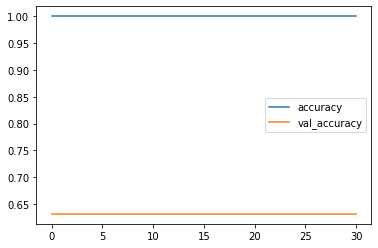

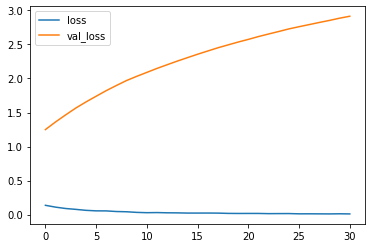

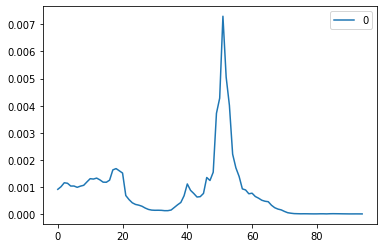

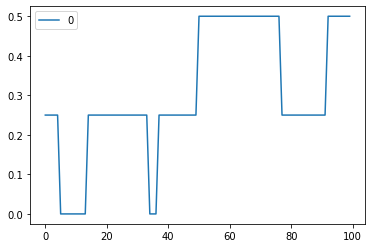

In [ ]:
df = pd.read_csv("/content/gdrive/My Drive/AMZN.csv")

df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']

df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df['1d'] = (df['mov5'].shift(-1) - df['mov5'])/df['mov5']
df['1w'] = (df['mov5'].shift(-5) - df['mov5'])/df['mov5']
df['2w'] = (df['mov5'].shift(-10) - df['mov5'])/df['mov5']
df['4w'] = (df['mov5'].shift(-20) - df['mov5'])/df['mov5']
df['6w'] = (df['mov5'].shift(-30) - df['mov5'])/df['mov5']
df['8w'] = (df['mov5'].shift(-40) - df['mov5'])/df['mov5']
df['10w'] = (df['mov5'].shift(-50) - df['mov5'])/df['mov5']
df['12w'] = (df['mov5'].shift(-60) - df['mov5'])/df['mov5']
df['18w'] = (df['mov5'].shift(-90) - df['mov5'])/df['mov5']
df['24w'] = (df['mov5'].shift(-120) - df['mov5'])/df['mov5']

df['return'] = (np.sort(df.iloc[:,14:],axis=1)[:,7] + np.sort(df.iloc[:,14:],axis=1)[:,6] + np.sort(df.iloc[:,14:],axis=1)[:,5])/3

df = df.dropna(axis=0)
df = df.iloc[-300:,:]

df['return'].describe()

# 수익율을 다시 구간화
def scaler01(row) :
  if row['return'] >= 0.2 : result = 3                # 초고수익율 구간
  elif 0.2 > row['return'] >= 0.1 : result = 2        # 고수익율 구간
  elif 0.1 > row['return'] >= 0.05 : result = 1       # 수익율 구간
  elif 0.05 > row['return'] >= 0.03 : result = 0.5    # 낮은 수익율 구간
  elif 0.03 > row['return'] >= 0.01 : result = 0.25   # 보전 구간(손실은 안나는)
  elif -0.2 < row['return'] <= -0.1 : result = -1     # 확정 손실 구간
  elif -0.3 < row['return'] <= -0.2 : result = -2     # 높은 손실 구간
  elif row['return'] <= -0.3 : result = -3            # 초고 손실 구간
  else : result = 0                                   # 손실 구간
  return result

df['return02'] = df.apply(scaler01,axis=1)

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
target = df['return02'].values

T = 5
D = input_data.shape[1] 
N = len(input_data) - T

# Scaling - must
Ntrain = len(input_data) * 2 // 3
scaler = MinMaxScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

pd.DataFrame(target).describe()

# Xtrain / Ytrain
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain) :
  X_train[t,:,:] = input_data[t:t+T]
  Y_train[t] = (target [t+T]>0.4) # 내부 조건

# Xtest Ytest

X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N-Ntrain)

for u in range(N-Ntrain):
    t = u + Ntrain
    X_test [u, :,:] = input_data[t:t+T]
    Y_test [u] = (target [t+T] >0.4)

# 정답 비율
print("train data % :",round(Y_train.sum()/(len(target)*2/3),4)*100, "test data % :",round(Y_test.sum()/(len(target)*1/3),4)*100)

from tensorflow.keras.models import load_model

model = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_03.hdf5")

# 모델 객체 만들고 훈련
X_train = X_train
X_train = X_train

X_test = X_test
X_test= X_test

r = model.fit([X_train, X_train], 
          Y_train,
          batch_size = 16,
          epochs = 200,
          validation_data = ([X_test, X_test], Y_test),
          callbacks = [early_stop,checkpointer] 
          )

#Converge
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

#Converge
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

pd.DataFrame(model.predict([X_test, X_test])).plot()
pd.DataFrame(target[Ntrain:]).plot()


# #3 TESLA

train data % : 60.5 test data % : 71.0
Epoch 1/200
13/13 [==============================] - 3s 70ms/step - loss: 1.1595 - accuracy: 0.3950 - val_loss: 1.6492 - val_accuracy: 0.2526

Epoch 00001: val_loss did not improve from 0.35654
Epoch 2/200
13/13 [==============================] - 0s 11ms/step - loss: 0.9781 - accuracy: 0.3950 - val_loss: 1.2428 - val_accuracy: 0.2526

Epoch 00002: val_loss did not improve from 0.35654
Epoch 3/200
13/13 [==============================] - 0s 10ms/step - loss: 0.8343 - accuracy: 0.4000 - val_loss: 1.0240 - val_accuracy: 0.2526

Epoch 00003: val_loss did not improve from 0.35654
Epoch 4/200
13/13 [==============================] - 0s 9ms/step - loss: 0.7738 - accuracy: 0.4050 - val_loss: 0.9013 - val_accuracy: 0.2526

Epoch 00004: val_loss did not improve from 0.35654
Epoch 5/200
13/13 [==============================] - 0s 8ms/step - loss: 0.7419 - accuracy: 0.4350 - val_loss: 0.8332 - val_accuracy: 0.2526

Epoch 00005: val_loss did not improve from 0

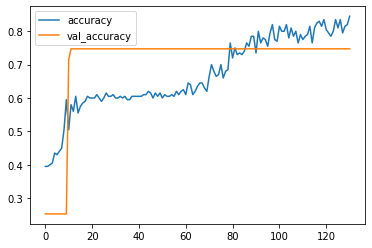

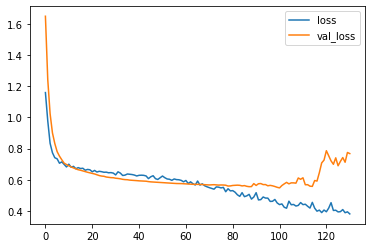

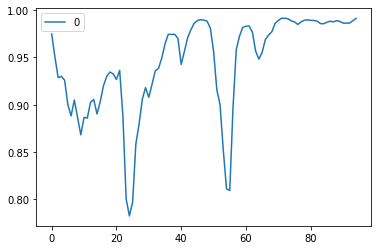

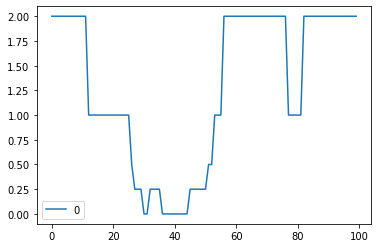

In [ ]:
df = pd.read_csv("/content/gdrive/My Drive/TSLA.csv")


df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']

df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df['1d'] = (df['mov5'].shift(-1) - df['mov5'])/df['mov5']
df['1w'] = (df['mov5'].shift(-5) - df['mov5'])/df['mov5']
df['2w'] = (df['mov5'].shift(-10) - df['mov5'])/df['mov5']
df['4w'] = (df['mov5'].shift(-20) - df['mov5'])/df['mov5']
df['6w'] = (df['mov5'].shift(-30) - df['mov5'])/df['mov5']
df['8w'] = (df['mov5'].shift(-40) - df['mov5'])/df['mov5']
df['10w'] = (df['mov5'].shift(-50) - df['mov5'])/df['mov5']
df['12w'] = (df['mov5'].shift(-60) - df['mov5'])/df['mov5']
df['18w'] = (df['mov5'].shift(-90) - df['mov5'])/df['mov5']
df['24w'] = (df['mov5'].shift(-120) - df['mov5'])/df['mov5']

df['return'] = (np.sort(df.iloc[:,14:],axis=1)[:,7] + np.sort(df.iloc[:,14:],axis=1)[:,6] + np.sort(df.iloc[:,14:],axis=1)[:,5])/3

df = df.dropna(axis=0)
df = df.iloc[-300:,:]

df['return'].describe()

# 수익율을 다시 구간화
def scaler01(row) :
  if row['return'] >= 0.2 : result = 3                # 초고수익율 구간
  elif 0.2 > row['return'] >= 0.1 : result = 2        # 고수익율 구간
  elif 0.1 > row['return'] >= 0.05 : result = 1       # 수익율 구간
  elif 0.05 > row['return'] >= 0.03 : result = 0.5    # 낮은 수익율 구간
  elif 0.03 > row['return'] >= 0.01 : result = 0.25   # 보전 구간(손실은 안나는)
  elif -0.2 < row['return'] <= -0.1 : result = -1     # 확정 손실 구간
  elif -0.3 < row['return'] <= -0.2 : result = -2     # 높은 손실 구간
  elif row['return'] <= -0.3 : result = -3            # 초고 손실 구간
  else : result = 0                                   # 손실 구간
  return result

df['return02'] = df.apply(scaler01,axis=1)

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
target = df['return02'].values

T = 5
D = input_data.shape[1] 
N = len(input_data) - T

# Scaling - must
Ntrain = len(input_data) * 2 // 3
scaler = MinMaxScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

pd.DataFrame(target).describe()

# Xtrain / Ytrain
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain) :
  X_train[t,:,:] = input_data[t:t+T]
  Y_train[t] = (target [t+T]>0.4) # 내부 조건

# Xtest Ytest

X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N-Ntrain)

for u in range(N-Ntrain):
    t = u + Ntrain
    X_test [u, :,:] = input_data[t:t+T]
    Y_test [u] = (target [t+T] >0.4)

# 정답 비율
print("train data % :",round(Y_train.sum()/(len(target)*2/3),4)*100, "test data % :",round(Y_test.sum()/(len(target)*1/3),4)*100)

from tensorflow.keras.models import load_model

model = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_03.hdf5")

# 모델 객체 만들고 훈련

r = model.fit([X_train, X_train], 
          Y_train,
          batch_size = 16,
          epochs = 200,
          validation_data = ([X_test, X_test], Y_test),
          callbacks = [early_stop,checkpointer] 
          )

#Converge
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

#Converge
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

pd.DataFrame(model.predict([X_test, X_test])).plot()
pd.DataFrame(target[Ntrain:]).plot()


# #4 APPLE

train data % : 48.5 test data % : 47.0
Epoch 1/200
13/13 [==============================] - 2s 47ms/step - loss: 1.1621 - accuracy: 0.5150 - val_loss: 0.9709 - val_accuracy: 0.5053

Epoch 00001: val_loss did not improve from 0.35654
Epoch 2/200
13/13 [==============================] - 0s 9ms/step - loss: 0.8933 - accuracy: 0.5150 - val_loss: 0.8158 - val_accuracy: 0.5053

Epoch 00002: val_loss did not improve from 0.35654
Epoch 3/200
13/13 [==============================] - 0s 8ms/step - loss: 0.7876 - accuracy: 0.5250 - val_loss: 0.7434 - val_accuracy: 0.5053

Epoch 00003: val_loss did not improve from 0.35654
Epoch 4/200
13/13 [==============================] - 0s 27ms/step - loss: 0.7305 - accuracy: 0.5300 - val_loss: 0.7114 - val_accuracy: 0.5053

Epoch 00004: val_loss did not improve from 0.35654
Epoch 5/200
13/13 [==============================] - 0s 10ms/step - loss: 0.7242 - accuracy: 0.5250 - val_loss: 0.6901 - val_accuracy: 0.5053

Epoch 00005: val_loss did not improve from 0

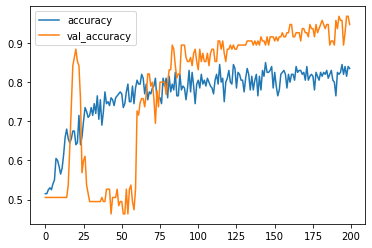

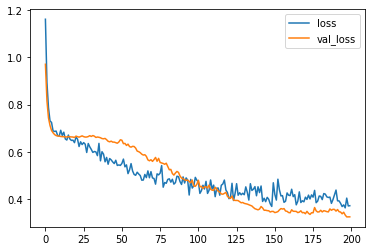

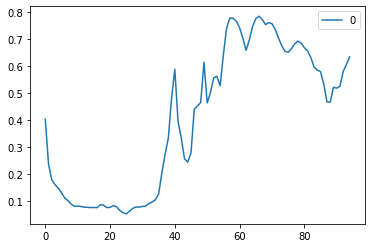

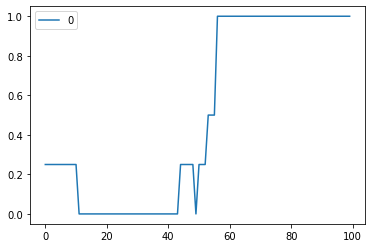

In [ ]:
df = pd.read_csv("/content/gdrive/My Drive/AAPL.csv")


df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']

df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df['1d'] = (df['mov5'].shift(-1) - df['mov5'])/df['mov5']
df['1w'] = (df['mov5'].shift(-5) - df['mov5'])/df['mov5']
df['2w'] = (df['mov5'].shift(-10) - df['mov5'])/df['mov5']
df['4w'] = (df['mov5'].shift(-20) - df['mov5'])/df['mov5']
df['6w'] = (df['mov5'].shift(-30) - df['mov5'])/df['mov5']
df['8w'] = (df['mov5'].shift(-40) - df['mov5'])/df['mov5']
df['10w'] = (df['mov5'].shift(-50) - df['mov5'])/df['mov5']
df['12w'] = (df['mov5'].shift(-60) - df['mov5'])/df['mov5']
df['18w'] = (df['mov5'].shift(-90) - df['mov5'])/df['mov5']
df['24w'] = (df['mov5'].shift(-120) - df['mov5'])/df['mov5']

df['return'] = (np.sort(df.iloc[:,14:],axis=1)[:,7] + np.sort(df.iloc[:,14:],axis=1)[:,6] + np.sort(df.iloc[:,14:],axis=1)[:,5])/3

df = df.dropna(axis=0)
df = df.iloc[-300:,:]

df['return'].describe()

# 수익율을 다시 구간화
def scaler01(row) :
  if row['return'] >= 0.2 : result = 3                # 초고수익율 구간
  elif 0.2 > row['return'] >= 0.1 : result = 2        # 고수익율 구간
  elif 0.1 > row['return'] >= 0.05 : result = 1       # 수익율 구간
  elif 0.05 > row['return'] >= 0.03 : result = 0.5    # 낮은 수익율 구간
  elif 0.03 > row['return'] >= 0.01 : result = 0.25   # 보전 구간(손실은 안나는)
  elif -0.2 < row['return'] <= -0.1 : result = -1     # 확정 손실 구간
  elif -0.3 < row['return'] <= -0.2 : result = -2     # 높은 손실 구간
  elif row['return'] <= -0.3 : result = -3            # 초고 손실 구간
  else : result = 0                                   # 손실 구간
  return result
df['return02'] = df.apply(scaler01,axis=1)

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
target = df['return02'].values

T = 5
D = input_data.shape[1] 
N = len(input_data) - T

# Scaling - must
Ntrain = len(input_data) * 2 // 3
scaler = MinMaxScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

pd.DataFrame(target).describe()

# Xtrain / Ytrain
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain) :
  X_train[t,:,:] = input_data[t:t+T]
  Y_train[t] = (target [t+T]>0.4) # 내부 조건

# Xtest Ytest

X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N-Ntrain)

for u in range(N-Ntrain):
    t = u + Ntrain
    X_test [u, :,:] = input_data[t:t+T]
    Y_test [u] = (target [t+T] >0.4)

# 정답 비율
print("train data % :",round(Y_train.sum()/(len(target)*2/3),4)*100, "test data % :",round(Y_test.sum()/(len(target)*1/3),4)*100)

from tensorflow.keras.models import load_model

model = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_03.hdf5")

# 모델 객체 만들고 훈련

r = model.fit([X_train, X_train], 
          Y_train,
          batch_size = 16,
          epochs = 200,
          validation_data = ([X_test, X_test], Y_test),
          callbacks = [early_stop,checkpointer] 
          )

#Converge
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

#Converge
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

pd.DataFrame(model.predict([X_test, X_test])).plot()
pd.DataFrame(target[Ntrain:]).plot()


# #5 INTEL

train data % : 24.0 test data % : 12.0
Epoch 1/200
13/13 [==============================] - 2s 47ms/step - loss: 0.7065 - accuracy: 0.6700 - val_loss: 1.7223 - val_accuracy: 0.4632

Epoch 00001: val_loss did not improve from 0.32299
Epoch 2/200
13/13 [==============================] - 0s 27ms/step - loss: 0.5234 - accuracy: 0.7200 - val_loss: 1.3102 - val_accuracy: 0.6000

Epoch 00002: val_loss did not improve from 0.32299
Epoch 3/200
13/13 [==============================] - 0s 9ms/step - loss: 0.4315 - accuracy: 0.7750 - val_loss: 1.1882 - val_accuracy: 0.6000

Epoch 00003: val_loss did not improve from 0.32299
Epoch 4/200
13/13 [==============================] - 0s 9ms/step - loss: 0.4061 - accuracy: 0.7950 - val_loss: 1.1515 - val_accuracy: 0.6000

Epoch 00004: val_loss did not improve from 0.32299
Epoch 5/200
13/13 [==============================] - 0s 9ms/step - loss: 0.4264 - accuracy: 0.7600 - val_loss: 1.0953 - val_accuracy: 0.6000

Epoch 00005: val_loss did not improve from 0.

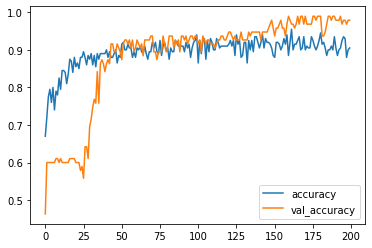

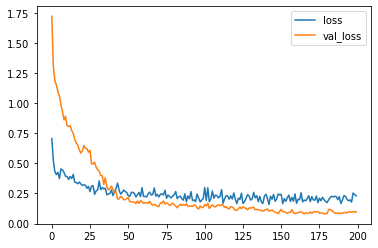

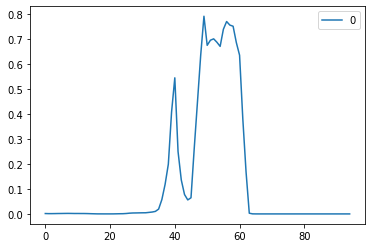

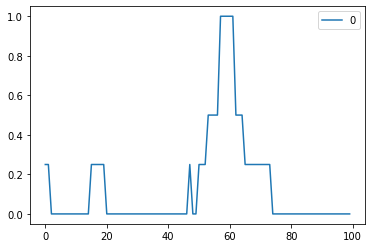

In [ ]:
df = pd.read_csv("/content/gdrive/My Drive/INTC.csv")


df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']

df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df['1d'] = (df['mov5'].shift(-1) - df['mov5'])/df['mov5']
df['1w'] = (df['mov5'].shift(-5) - df['mov5'])/df['mov5']
df['2w'] = (df['mov5'].shift(-10) - df['mov5'])/df['mov5']
df['4w'] = (df['mov5'].shift(-20) - df['mov5'])/df['mov5']
df['6w'] = (df['mov5'].shift(-30) - df['mov5'])/df['mov5']
df['8w'] = (df['mov5'].shift(-40) - df['mov5'])/df['mov5']
df['10w'] = (df['mov5'].shift(-50) - df['mov5'])/df['mov5']
df['12w'] = (df['mov5'].shift(-60) - df['mov5'])/df['mov5']
df['18w'] = (df['mov5'].shift(-90) - df['mov5'])/df['mov5']
df['24w'] = (df['mov5'].shift(-120) - df['mov5'])/df['mov5']

df['return'] = (np.sort(df.iloc[:,14:],axis=1)[:,7] + np.sort(df.iloc[:,14:],axis=1)[:,6] + np.sort(df.iloc[:,14:],axis=1)[:,5])/3

df = df.dropna(axis=0)
df = df.iloc[-300:,:]

df['return'].describe()

# 수익율을 다시 구간화
def scaler01(row) :
  if row['return'] >= 0.2 : result = 3                # 초고수익율 구간
  elif 0.2 > row['return'] >= 0.1 : result = 2        # 고수익율 구간
  elif 0.1 > row['return'] >= 0.05 : result = 1       # 수익율 구간
  elif 0.05 > row['return'] >= 0.03 : result = 0.5    # 낮은 수익율 구간
  elif 0.03 > row['return'] >= 0.01 : result = 0.25   # 보전 구간(손실은 안나는)
  elif -0.2 < row['return'] <= -0.1 : result = -1     # 확정 손실 구간
  elif -0.3 < row['return'] <= -0.2 : result = -2     # 높은 손실 구간
  elif row['return'] <= -0.3 : result = -3            # 초고 손실 구간
  else : result = 0                                   # 손실 구간
  return result

df['return02'] = df.apply(scaler01,axis=1)

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
target = df['return02'].values

T = 5
D = input_data.shape[1] 
N = len(input_data) - T

# Scaling - must
Ntrain = len(input_data) * 2 // 3
scaler = MinMaxScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

pd.DataFrame(target).describe()

# Xtrain / Ytrain
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain) :
  X_train[t,:,:] = input_data[t:t+T]
  Y_train[t] = (target [t+T]>0.4) # 내부 조건

# Xtest Ytest

X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N-Ntrain)

for u in range(N-Ntrain):
    t = u + Ntrain
    X_test [u, :,:] = input_data[t:t+T]
    Y_test [u] = (target [t+T] >0.4)

# 정답 비율
print("train data % :",round(Y_train.sum()/(len(target)*2/3),4)*100, "test data % :",round(Y_test.sum()/(len(target)*1/3),4)*100)

from tensorflow.keras.models import load_model

model = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_03.hdf5")

# 모델 객체 만들고 훈련

r = model.fit([X_train, X_train], 
          Y_train,
          batch_size = 16,
          epochs = 200,
          validation_data = ([X_test, X_test], Y_test),
          callbacks = [early_stop,checkpointer] 
          )

#Converge
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

#Converge
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

pd.DataFrame(model.predict([X_test, X_test])).plot()
pd.DataFrame(target[Ntrain:]).plot()


# #6 AMD

train data % : 62.5 test data % : 41.0
Epoch 1/200
13/13 [==============================] - 2s 47ms/step - loss: 2.2530 - accuracy: 0.4850 - val_loss: 1.9672 - val_accuracy: 0.5684

Epoch 00001: val_loss did not improve from 0.08001
Epoch 2/200
13/13 [==============================] - 0s 11ms/step - loss: 0.9814 - accuracy: 0.5700 - val_loss: 1.1189 - val_accuracy: 0.5789

Epoch 00002: val_loss did not improve from 0.08001
Epoch 3/200
13/13 [==============================] - 0s 10ms/step - loss: 0.8354 - accuracy: 0.5400 - val_loss: 0.8861 - val_accuracy: 0.5684

Epoch 00003: val_loss did not improve from 0.08001
Epoch 4/200
13/13 [==============================] - 0s 11ms/step - loss: 0.8558 - accuracy: 0.5150 - val_loss: 0.8148 - val_accuracy: 0.5579

Epoch 00004: val_loss did not improve from 0.08001
Epoch 5/200
13/13 [==============================] - 0s 11ms/step - loss: 0.7316 - accuracy: 0.5650 - val_loss: 0.8232 - val_accuracy: 0.5579

Epoch 00005: val_loss did not improve from

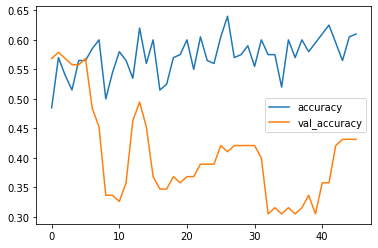

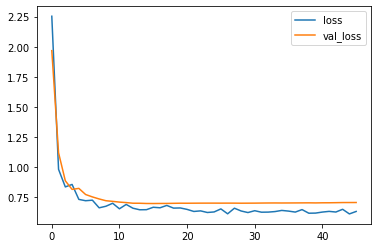

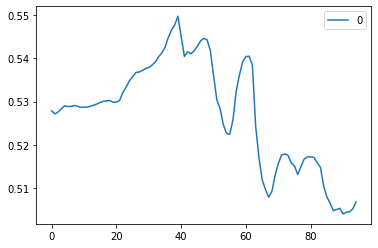

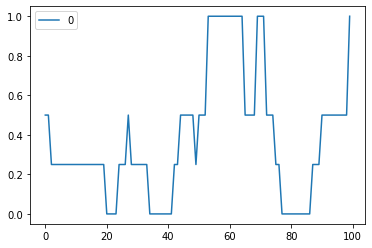

In [ ]:
df = pd.read_csv("/content/gdrive/My Drive/AMD.csv")

df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']

df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df['1d'] = (df['mov5'].shift(-1) - df['mov5'])/df['mov5']
df['1w'] = (df['mov5'].shift(-5) - df['mov5'])/df['mov5']
df['2w'] = (df['mov5'].shift(-10) - df['mov5'])/df['mov5']
df['4w'] = (df['mov5'].shift(-20) - df['mov5'])/df['mov5']
df['6w'] = (df['mov5'].shift(-30) - df['mov5'])/df['mov5']
df['8w'] = (df['mov5'].shift(-40) - df['mov5'])/df['mov5']
df['10w'] = (df['mov5'].shift(-50) - df['mov5'])/df['mov5']
df['12w'] = (df['mov5'].shift(-60) - df['mov5'])/df['mov5']
df['18w'] = (df['mov5'].shift(-90) - df['mov5'])/df['mov5']
df['24w'] = (df['mov5'].shift(-120) - df['mov5'])/df['mov5']

df['return'] = (np.sort(df.iloc[:,14:],axis=1)[:,7] + np.sort(df.iloc[:,14:],axis=1)[:,6] + np.sort(df.iloc[:,14:],axis=1)[:,5])/3

df = df.dropna(axis=0)
df = df.iloc[-300:,:]

df['return'].describe()

# 수익율을 다시 구간화
def scaler01(row) :
  if row['return'] >= 0.2 : result = 3                # 초고수익율 구간
  elif 0.2 > row['return'] >= 0.1 : result = 2        # 고수익율 구간
  elif 0.1 > row['return'] >= 0.05 : result = 1       # 수익율 구간
  elif 0.05 > row['return'] >= 0.03 : result = 0.5    # 낮은 수익율 구간
  elif 0.03 > row['return'] >= 0.01 : result = 0.25   # 보전 구간(손실은 안나는)
  elif -0.2 < row['return'] <= -0.1 : result = -1     # 확정 손실 구간
  elif -0.3 < row['return'] <= -0.2 : result = -2     # 높은 손실 구간
  elif row['return'] <= -0.3 : result = -3            # 초고 손실 구간
  else : result = 0                                   # 손실 구간
  return result

df['return02'] = df.apply(scaler01,axis=1)

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
target = df['return02'].values

T = 5
D = input_data.shape[1] 
N = len(input_data) - T

# Scaling - must
Ntrain = len(input_data) * 2 // 3
scaler = MinMaxScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

pd.DataFrame(target).describe()

# Xtrain / Ytrain
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain) :
  X_train[t,:,:] = input_data[t:t+T]
  Y_train[t] = (target [t+T]>0.4) # 내부 조건

# Xtest Ytest

X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N-Ntrain)

for u in range(N-Ntrain):
    t = u + Ntrain
    X_test [u, :,:] = input_data[t:t+T]
    Y_test [u] = (target [t+T] >0.4)

# 정답 비율
print("train data % :",round(Y_train.sum()/(len(target)*2/3),4)*100, "test data % :",round(Y_test.sum()/(len(target)*1/3),4)*100)


from tensorflow.keras.models import load_model

model = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_03.hdf5")

# 모델 객체 만들고 훈련

r = model.fit([X_train, X_train], 
          Y_train,
          batch_size = 16,
          epochs = 200,
          validation_data = ([X_test, X_test], Y_test),
          callbacks = [early_stop,checkpointer] 
          )

#Converge
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

#Converge
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

pd.DataFrame(model.predict([X_test, X_test])).plot()
pd.DataFrame(target[Ntrain:]).plot()


# #7 RE:STARBUCKS

train data % : 5.5 test data % : 18.0
Epoch 1/200
13/13 [==============================] - 3s 67ms/step - loss: 0.6368 - accuracy: 0.8700 - val_loss: 2.0217 - val_accuracy: 0.4632

Epoch 00001: val_loss did not improve from 0.08001
Epoch 2/200
13/13 [==============================] - 0s 9ms/step - loss: 0.5410 - accuracy: 0.9150 - val_loss: 1.8189 - val_accuracy: 0.5895

Epoch 00002: val_loss did not improve from 0.08001
Epoch 3/200
13/13 [==============================] - 0s 9ms/step - loss: 0.4408 - accuracy: 0.9200 - val_loss: 1.6977 - val_accuracy: 0.6000

Epoch 00003: val_loss did not improve from 0.08001
Epoch 4/200
13/13 [==============================] - 0s 9ms/step - loss: 0.5137 - accuracy: 0.9350 - val_loss: 1.6274 - val_accuracy: 0.6000

Epoch 00004: val_loss did not improve from 0.08001
Epoch 5/200
13/13 [==============================] - 0s 9ms/step - loss: 0.4046 - accuracy: 0.9150 - val_loss: 1.5301 - val_accuracy: 0.6105

Epoch 00005: val_loss did not improve from 0.08

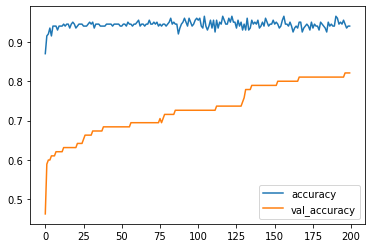

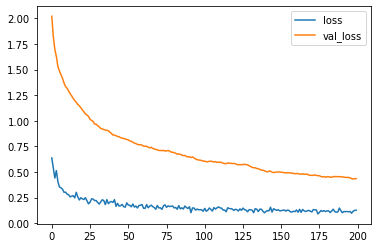

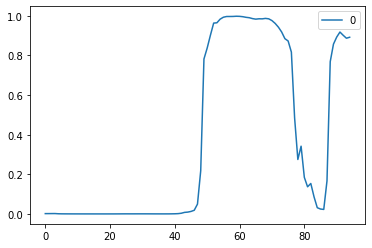

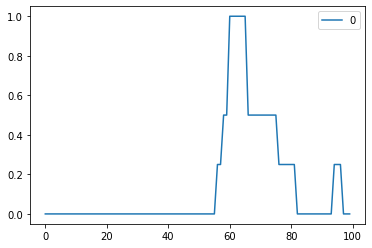

In [ ]:
df = pd.read_csv("/content/gdrive/My Drive/SBUX_rev.2.csv")

df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']

df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df['1d'] = (df['mov5'].shift(-1) - df['mov5'])/df['mov5']
df['1w'] = (df['mov5'].shift(-5) - df['mov5'])/df['mov5']
df['2w'] = (df['mov5'].shift(-10) - df['mov5'])/df['mov5']
df['4w'] = (df['mov5'].shift(-20) - df['mov5'])/df['mov5']
df['6w'] = (df['mov5'].shift(-30) - df['mov5'])/df['mov5']
df['8w'] = (df['mov5'].shift(-40) - df['mov5'])/df['mov5']
df['10w'] = (df['mov5'].shift(-50) - df['mov5'])/df['mov5']
df['12w'] = (df['mov5'].shift(-60) - df['mov5'])/df['mov5']
df['18w'] = (df['mov5'].shift(-90) - df['mov5'])/df['mov5']
df['24w'] = (df['mov5'].shift(-120) - df['mov5'])/df['mov5']

df['return'] = (np.sort(df.iloc[:,14:],axis=1)[:,7] + np.sort(df.iloc[:,14:],axis=1)[:,6] + np.sort(df.iloc[:,14:],axis=1)[:,5])/3

df = df.dropna(axis=0)
df = df.iloc[-300:,:]

df['return'].describe()

# 수익율을 다시 구간화
def scaler01(row) :
  if row['return'] >= 0.2 : result = 3                # 초고수익율 구간
  elif 0.2 > row['return'] >= 0.1 : result = 2        # 고수익율 구간
  elif 0.1 > row['return'] >= 0.05 : result = 1       # 수익율 구간
  elif 0.05 > row['return'] >= 0.03 : result = 0.5    # 낮은 수익율 구간
  elif 0.03 > row['return'] >= 0.01 : result = 0.25   # 보전 구간(손실은 안나는)
  elif -0.2 < row['return'] <= -0.1 : result = -1     # 확정 손실 구간
  elif -0.3 < row['return'] <= -0.2 : result = -2     # 높은 손실 구간
  elif row['return'] <= -0.3 : result = -3            # 초고 손실 구간
  else : result = 0                                   # 손실 구간
  return result

df['return02'] = df.apply(scaler01,axis=1)

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
target = df['return02'].values

T = 5
D = input_data.shape[1] 
N = len(input_data) - T

# Scaling - must
Ntrain = len(input_data) * 2 // 3
scaler = MinMaxScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

pd.DataFrame(target).describe()

# Xtrain / Ytrain
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain) :
  X_train[t,:,:] = input_data[t:t+T]
  Y_train[t] = (target [t+T]>0.4) # 내부 조건

# Xtest Ytest

X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N-Ntrain)

for u in range(N-Ntrain):
    t = u + Ntrain
    X_test [u, :,:] = input_data[t:t+T]
    Y_test [u] = (target [t+T] >0.4)

# 정답 비율
print("train data % :",round(Y_train.sum()/(len(target)*2/3),4)*100, "test data % :",round(Y_test.sum()/(len(target)*1/3),4)*100)


from tensorflow.keras.models import load_model

model = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_03.hdf5")

# 모델 객체 만들고 훈련

r = model.fit([X_train, X_train], 
          Y_train,
          batch_size = 16,
          epochs = 200,
          validation_data = ([X_test, X_test], Y_test),
          callbacks = [early_stop,checkpointer] 
          )

#Converge
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

#Converge
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

pd.DataFrame(model.predict([X_test, X_test])).plot()
pd.DataFrame(target[Ntrain:]).plot()
